# EDA & Hypothesis Testing on Data from Yelp on the Bay Area Tri-Cities

## Imports

In [1]:
# necessary imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Inspection & Preliminary Cleaning

I start by first reading the scraped data into a pandas DataFrame:

In [2]:
tri_city_df = pd.read_csv('tri_city_data.csv')
tri_city_df = tri_city_df.drop_duplicates() # There are duplicates in the data that need to be dropped
tri_city_df.head()

,business_id,name,city,review_count,rating
0,CcbFduunKlsrnW71-PH0ZA,Pocha K,newark,55,4.5
1,purj1aiUzDi0I__qLOaNRg,四姐 Pan Fried Dumplings,newark,613,4.5
2,1y4juqtkSJ9DPPZyRMi-xA,Mingkee Deli,newark,17,3.5
3,9Shb0yRis5NEQ5xIGG0FcA,Duobao BBQ & Dumplings,newark,43,4.5
4,i_GuYJ_1hmW-lHeQ4GmOiw,Lazy Dog Restaurant & Bar,newark,1617,4.0


As expected from the way I scraped the Yelp data and wrote into `tri_city_data.csv`, the `tri_city_df` schema is:
* Each tuple is a unique business containing the features:
    * `business_id`: the primary key of the business
    * `name`: name of the business
    * `city`: the city the business is located in
    * `review_count`: total number of reviews the business recived as of 4/13/2023
    * `rating`: the cumulative rating calculated from the reviews the business received as of 4/13/2023

Before moving on to proper EDA, I realized I needed to some some preliminary cleaning.

In the `name` column, it appears that the apostrophe character in the data **’** is somehow *different* from the apostrophe character on my keyboard **'**. The former seems to be curved whereas the latter is straight. A quick Google search led me to this [Stack Overflow post](https://stackoverflow.com/questions/6711892/right-single-apostrophe-vs-apostrophe). To deal with this, I will use regex to replace the slanted apostrophe with the straight apostrophe.

In [3]:
# Replace slanted apostrophe ’ with straight apostrophe '
tri_city_df['name'] = tri_city_df['name'].str.replace("’", "'")

# Check if properly replaced
print("McDonald's" in tri_city_df['name'].values)

True


The check returned `True`, meaning the replacement was successful. 

Next, I need to categorize each business as whether or not it is a commonly franchised fast food restaurant. I create a new feature called `is_ff_chain`, which will take on value $1$ if it is a commonly franchised fast food restaurant as defined by the list mentioned in the README, otherwise $0$.

The list is reproduced here:
`["Burger King", "Carl's Jr", "Chick-fil-A",  "Chipotle Mexican Grill", "McDonald's",
                 "Firehouse Subs", "Five Guys", "Jack in the Box", "KFC", "Panda Express",
                 "Papa Johns Pizza", "Popeyes Louisiana Kitchen", "Subway", "Taco Bell",
                 "Wendy's", "Wienerschnitzel", "Wingstop"]`

In [4]:
# Defined list
ff_chain_list = ["Burger King", "Carl's Jr", "Chick-fil-A",  "Chipotle Mexican Grill", "McDonald's",
                 "Firehouse Subs", "Five Guys", "Jack in the Box", "KFC", "Panda Express",
                 "Papa Johns Pizza", "Popeyes Louisiana Kitchen", "Subway", "Taco Bell",
                 "Wendy's", "Wienerschnitzel", "Wingstop"]

# Create new feature `is_ff_chain`
tri_city_df['is_ff_chain'] = tri_city_df['name'].isin(ff_chain_list)

## Exploration

Starting with something simple, I was curious about the proportion of commonly franchised fast food restaurants (fast food chains) to restaurants in the Tri-City area.

In [5]:
# Display number of commonly franchised fast food restaurants (ff_chains) are in the tri-city area
print("Num ff_chains: {:27}".format(len(tri_city_df[tri_city_df['is_ff_chain']])))

# Display number of total restaurants in tri-city area
print("Num restaurants: {:26}".format(len(tri_city_df)))

# Display proportion of ff_chains in tri-city area
print("Proportion of ff_chains to restaurants: {0:.4f}".format(len(tri_city_df[tri_city_df['is_ff_chain']])/len(tri_city_df) ))

Num ff_chains:                          63
Num restaurants:                        365
Proportion of ff_chains to restaurants: 0.1726


Roughly $17\%$ of all restaurants in the Tri-City area are fast food chains. Not sure how significant this number is, but this seems to be quite a lot. Might be a cool topic to look into in a future project.

Next, I wanted to see the distribution of ratings for ff_chains and non-fast-food restaurants.

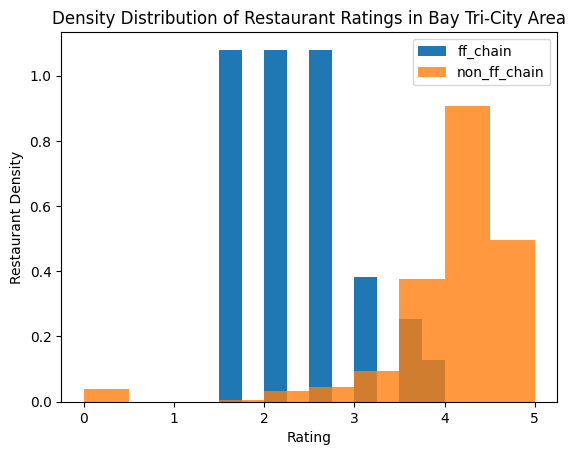

In [6]:
# Get series of ff_chain ratings
ff_chain_rating_series = tri_city_df[tri_city_df['is_ff_chain']]['rating']

# Get series of non ff_chain ratings
non_ff_chain_rating_series = tri_city_df[~tri_city_df['is_ff_chain']]['rating']

# Plot the two histograms overlaid
plt.hist(ff_chain_rating_series, alpha=1, label='ff_chain', density=True)
plt.hist(non_ff_chain_rating_series, alpha=0.8, label='non_ff_chain', density=True)
plt.legend()
plt.title("Density Distribution of Restaurant Ratings in Bay Tri-City Area")
plt.xlabel('Rating')
plt.ylabel('Restaurant Density')
plt.show()

Observations:
* `ff_chain` distribution:
    * Centered around $2.5$.
    * Three peaks, one at $1.5, second at $2$, and third and $2.5$.
    * Exhibits a right skew, meaning mean $>$ median.
* `non_ff_chain` distribution:
    * Centered around $4$.
    * Unimodal, one peak at around $4$.
    * Exhibits a left skew, meaning mean $<$ median.

In comparing the two distribution densities, I think it is quite clear that the rating distribution for fast food chains is based to the left of that of normal restaurants. In other words, the ratings of fast food chains are on average lower than the ratings of normal restaurants.

These observations now raise my main question:

**Is the difference in ratings simply a result of chance variation or is there a *real* difference between the two distributions?**

## Hypothesis Testing - A/B Test

To answer the question posed in exploration, I will perform an A/B test with the following hypotheses:

**Null Hypothesis:** In the Bay Area Tri-City area, the distribution of ratings is the same for regular restaurants and commonly franchised fast food restaurants. The difference in the sample is due to chance.

**Alternative Hypothesis:** In the Bay Area Tri-City area, the commonly franchised fast food restaurants have a *lower* rating, on average, than regular restaurants.

For my test statistic, I will be using the difference between the two group's rating averages, specifically the average rating of non-fast-food chain restaurants *minus* the average rating of fast food chains. This means that larger values will favor the alternative hypothesis. A naive $\alpha=0.05$ will be used as the cutoff point.

To start, I will compute the observed value of the test statistic.

In [7]:
# Display the average rating of the two groups
average_ratings = tri_city_df[['rating', 'is_ff_chain']].groupby('is_ff_chain').mean()
print(average_ratings)

# Compute the test statistic (0th value is regular restaurants, 1st is chain)
obs_diff = average_ratings.values[0][0] - average_ratings.values[1][0]
print('\nObserved Difference: {:.4f}'.format(obs_diff))

               rating
is_ff_chain          
False        3.841060
True         2.253968

Observed Difference: 1.5871


The observed test statistic, or the difference in average ratings between the two groups, non-fast-food chain average rating minus fast food chain average rating, is around $1.60$.

Next, I will implement a Python function that performs A/B testing: shuffling labels, simulating samples, and compute the test statistic.

In [8]:
# Function that performs the A/B test.
# Takes in the DataFrame, the name of the column to be averaged, and the label to group by
# Plots the distribution density of the average differences, concludes whether or not to reject
# the null hypotheseis, and returns the empirical p-value

def ab_test(df, col, group, rep, obs_diff, alpha):

    # Helper function for ONE simulation of the hypothesis test
    def simulate_test(df, group):
        # Shuffle labels, must sample with replacement
        new_labels = df.sample(len(df), replace=True).reset_index()[group]
        # Project desired columns and add shuffled labels
        sample_df = df[[col]] # projection
        sample_df['shuffled_label'] = new_labels
        # Get averages of the two groups (0th value is regular restaurants, 1st is chain)
        sample_df_series = sample_df.groupby('shuffled_label').mean()
        sample_diff = sample_df_series[col][0] - sample_df[col][1]
        return sample_diff
    
    # Use helper function to compute test statistic. Repeat for rep repetitions
    test_statistic_list = np.array([])
    for _ in np.arange(rep):
        sim_test_statistic = simulate_test(df, group)
        test_statistic_list = np.append(test_statistic_list, sim_test_statistic)
    
    empirical_p = np.count_nonzero(test_statistic_list >= obs_diff)/ rep

    # Plot the distribution density of the average differences
    plt.hist(test_statistic_list, density=True)
    plt.grid()
    plt.scatter(obs_diff, 0.2, color='red')
    plt.title('Density Distribution of Average Differences Under the Null')
    plt.xlabel('Average Difference')
    plt.ylabel('Average Difference Density')

    # Print conclusions
    print('Simulation under the Null with {} repetitions'.format(rep))
    print("With naive \u03B1={} and empirical p-value={},".format(alpha, empirical_p))
    print("we {} the null hypothesis".format("FAIL TO REJECT" if empirical_p > alpha else "REJECT"))
    return empirical_p
        




With the `ab_test` function implemented, I now perform the A/B test:

Simulation under the Null with 5000 repetitions
With naive α=0.05 and empirical p-value=0.0,
we REJECT the null hypothesis


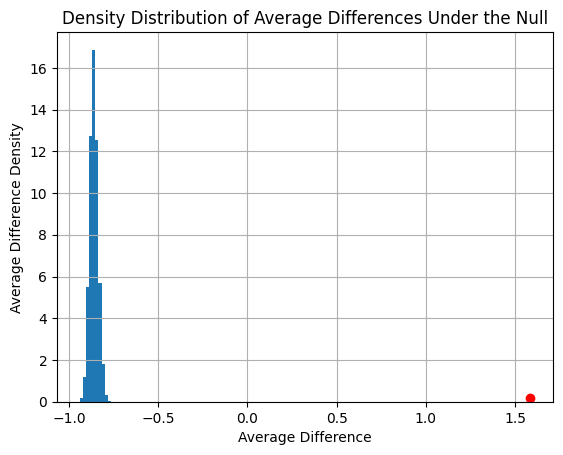

In [9]:
# Suppress SwettingwithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Perform the A/B test
empirical_p = ab_test(tri_city_df, 'rating', 'is_ff_chain', 5000, obs_diff, 0.05)

Reiterating again the parameters of my A/B test. With a naive $\alpha=0.05$, our p-value cutoff, and by simulating under the null hypothesis, I obtained a p-value of $0.0$, and computation is reinforced by the histogram. The histogram is centered around $0.1$, mostly unimodal, and with very little spread, and we can see that our observed value (the red dot) is way far off to the right of the plot.

Finally, since our empirical p-value of $0.0$ is ***less** than our $\alpha=0.05$, we reject our null hypothesis and lean towards the alternative, meaning our test supports the hypothesis that in the Bay Tri-City area, commonly franchised fast food restaurants or fast food chains have lower ratings on average than regular restaurants.